## Implementation of Reptile in Tensorflow 2.0

This implementation are influenced by :
- Pytorch implementation by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)
- MAML implementation on Tensorflow 2.0 by Marianne Monteiro : [Reproduction of MAML using TensorFlow 2.0.](https://github.com/mari-linhares/tensorflow-maml)

Github : https://github.com/hfahrudin

Facebook : https://www.facebook.com/hasby.fahrudin

### Reptile : On First-Order Meta-Learning Algorithms

https://arxiv.org/abs/1803.02999

> ... It also includes Reptile, a new algorithm that we introduce here, which works by repeatedly sampling
a task, training on it, and moving the initialization towards the trained weights on that task.
We expand on the results from Finn et al. showing that first-order meta-learning algorithms
perform well on some well-established benchmarks for few-shot classification, and we provide
theoretical analysis aimed at understanding why these algorithms work.

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend


import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)
tf.keras.backend.set_floatx('float64')
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

Python version:  3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:18:16) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.0.0
GPU found at: /device:GPU:0


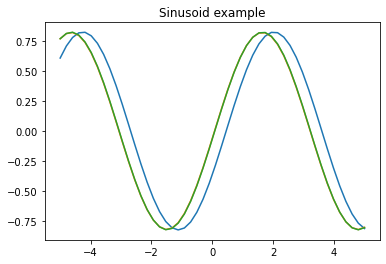

In [ ]:
class SinusoidGenerator() :

    def __init__ (self, K=None, amplitude = None, phase = None):
        self.K = K
        self.amplitude = amplitude if amplitude else np.random.uniform(0.1, 1.0)
        self.phase = phase*np.pi if phase else np.random.uniform(0,  0.2*np.pi)
        self.x = self._sample_x()

    def _sample_x(self):
        return np.random.uniform(-5,5, self.K)

    def f(self, x):
        return self.amplitude * np.sin(x - self.phase)

    def batch(self, x=None, force_new = False):
        if x is None:
            if force_new:
                x = self._sample_x()
            else:
                x = self.x
        y = self.f(x)
        return x[:, None], y[:, None]

    def equally_spaced_samples(self, K= None):
        if K is None:
            K = self.K
        return self.batch (x = np.linspace(-5, 5, K))

    def random_spaced_samples(self, K= None):
        if K is None:
            K = self.K
        return self.batch(x = np.random.uniform(-5, 5, K))

def plot (data, *args, **kwargs):
    x,y = data
    return plt.plot(x, y, *args, **kwargs)

plt.figure()
for _ in range(3):
    plt.title('Sinusoid example')
    plot(SinusoidGenerator(K=50).equally_spaced_samples())
plt.show()


In [ ]:
def generate_dataset (K, amplitude = None, phase = None, size=1000):
    return [SinusoidGenerator(K, amplitude, phase) for _ in range(size)]




In [ ]:
train_ds = generate_dataset(K=100)

In [ ]:
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)

    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [ ]:
def loss_function(pred_y, y):
    return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)


def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits

def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
def copy_model(model, x=None):
    '''Copy model weights to a new model.

    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''

    copied_model = SineModel()

    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))

    copied_model.set_weights(model.get_weights())
    return copied_model


### Train regular model for comparison

In [ ]:
def train_reg(epochs, dataset,mdl=None, lr=0.001, log_steps=100):
    if mdl is not None :
        model = mdl
    else:
        model = SineModel()
    optimizer = keras.optimizers.Adam(learning_rate = lr)
    losses = []
    for epoch in range(epochs):
        if log_steps is not None:
            print("====== Epoch : " +str(epoch)+ " ====== ")

        total_loss = 0
        curr_loss = 0
        tmp = 0
        for i, sinusoid_generator in enumerate(dataset):
            x, y = sinusoid_generator.batch()
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)

            tmp = i
            if log_steps is not None:
                if i % log_steps == 0 and i > 0:
                    print('Step {}: loss = {}'.format(i, curr_loss))
        losses.append(curr_loss)
    plt.plot(losses)
    plt.xlabel("Adaptation steps")
    plt.title("Mean Absolute Error Performance (Normal)")
    plt.ylabel("Loss")
    plt.show()
    return model, np.array(losses)

====== Epoch : 0 ====== 
Step 100: loss = 0.17034819826857758
Step 200: loss = 0.13364604364270535
Step 300: loss = 0.10863433885946842
Step 400: loss = 0.09370393506371463
Step 500: loss = 0.08397972504417063
Step 600: loss = 0.07802899805846426
Step 700: loss = 0.07264766997936717
Step 800: loss = 0.07019724055476206
Step 900: loss = 0.06710143074001197
====== Epoch : 1 ====== 
Step 100: loss = 0.044885891149887724
Step 200: loss = 0.04414367487409486
Step 300: loss = 0.04389841074365887
Step 400: loss = 0.04417911083379855
Step 500: loss = 0.044195204537916866
Step 600: loss = 0.04457699054042391
Step 700: loss = 0.04378075996839058
Step 800: loss = 0.04475035640551715
Step 900: loss = 0.04436215850356822
====== Epoch : 2 ====== 
Step 100: loss = 0.04393650568591537
Step 200: loss = 0.043178573317996106
Step 300: loss = 0.042901586429886944
Step 400: loss = 0.04326748095792074
Step 500: loss = 0.04335949080900651
Step 600: loss = 0.043747920388166446
Step 700: loss = 0.0429809157830

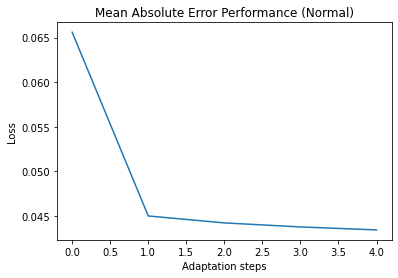

In [ ]:
nn = train_reg(5, train_ds)

### Train Reptile

![Capture](https://user-images.githubusercontent.com/25025173/80688197-6774e480-8b06-11ea-9e95-728ed2647a83.PNG)

In [ ]:
def train_reptile( epochs, dataset, mdl=None, lr_inner=0.001, lr_outer=0.01, batch_size=1, log_steps=100, k=1):
    #Step 1 : initialize model
    if mdl is not None :
        model = mdl
    else:
        model = SineModel()
    inner_optimizer = keras.optimizers.SGD(learning_rate=lr_inner)
    outer_optimizer = keras.optimizers.Adam(learning_rate=lr_outer)
    losses = []

    # Step 2 : iteration
    for epoch in range(epochs):
        if log_steps is not None:
            print("====== Epoch : " +str(epoch)+ " ====== ")
        total_loss = 0

        start = time.time()
        #Step 3 & 4 : get sample task from dataset
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            model.forward(x)

            # save current parameter
            old_weights = model.get_weights()

            model_copy = copy_model(model, x)
            # Step 5 : Compute W with SGD
            for _ in range(k):
                loss = train_batch(x, y, model_copy, inner_optimizer)

            # Step 6 : update model parameter
            after_weights = model_copy.get_weights()
            step_size = lr_inner * (1 - epoch / epochs) # linear scheduling method
            new_weights = [ old_weights[i] + ((old_weights[i] - after_weights[i]) * step_size)
                           for i in range(len(model.weights))]
            model.set_weights(new_weights)

            # additional step for outer optimization
            if (i+1) % batch_size == 0:
                test_loss = train_batch(x, y, model, outer_optimizer)
            else:
                test_loss, logits = compute_loss(model, x, y)

            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)

            if log_steps is not None:
                if i % log_steps == 0 and i > 0:
                    print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                    start = time.time()

        losses.append(loss)
    plt.plot(losses)
    plt.xlabel("Adaptation steps")
    plt.title("Mean Absolute Error Performance (REPTILE)")
    plt.ylabel("Loss")
    plt.show()
    return model, np.array(losses)

====== Epoch : 0 ====== 
Step 100: loss = 0.11630262319964045, Time to run 100 steps = 3.9594130516052246
Step 200: loss = 0.08616197079764036, Time to run 100 steps = 3.823777675628662
Step 300: loss = 0.07816224173262722, Time to run 100 steps = 3.8267922401428223
Step 400: loss = 0.06997471052864888, Time to run 100 steps = 3.8107872009277344
Step 500: loss = 0.06658417944784387, Time to run 100 steps = 3.811807632446289
Step 600: loss = 0.0643197555030843, Time to run 100 steps = 3.8277664184570312
Step 700: loss = 0.06134649617756716, Time to run 100 steps = 3.8337509632110596
Step 800: loss = 0.05980684729426915, Time to run 100 steps = 3.8078503608703613
Step 900: loss = 0.05756203839545279, Time to run 100 steps = 3.8197872638702393
====== Epoch : 1 ====== 
Step 100: loss = 0.05420163203246391, Time to run 100 steps = 3.8796277046203613
Step 200: loss = 0.04853950270389763, Time to run 100 steps = 3.8038573265075684
Step 300: loss = 0.04635464093933263, Time to run 100 steps = 

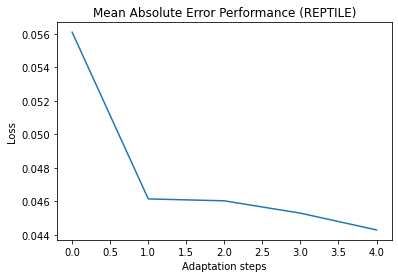

In [ ]:
reptile = train_reptile(5, train_ds)

### Test session

This test are comparing regular model vs reptile model with discrepancy in data compared to initial training. We would like to know how reptile perform while discrepancy getting bigger. The model will be trained in 100 task per discrepancy setup in 10 epochs each for 3 times and we will calculate the average of loss for better comparison variable.

In [ ]:
x_copy, _ = train_ds[0].batch()
def test_session(model, train_func):
    all_losses = []
    p = [0.3 , 0.5, 0.7, 0.9, 1]
    for i in range (0,5):
        title = "Amplitude : "+ str((i+2)) + " Phase : "+ str(p[i])+"*phi)"
        print(title)
        last_losses = 0
        all_res = []
        for j in range(0, 5):
            print("======= ", j+1, " run ========")
            test_task = [SinusoidGenerator(K=100, amplitude = i+2 , phase=p[i])]
            cp_model = copy_model(model, x_copy)
            res = train_func(epochs=100, mdl=cp_model, dataset=test_task, log_steps=None)
            all_res.append(res[1])
            last_losses+=res[1][-1]
        plt.plot(all_res[0])
        plt.plot(all_res[1])
        plt.plot(all_res[2])
        plt.plot(all_res[3])
        plt.plot(all_res[4])
        plt.title(title)
        plt.legend(["Run 1", "Run 2", "Run 3", "Run 4", "Run 5"], loc=(1.05, 0.5))
        plt.xlabel("Adaptation steps")
        plt.ylabel("Loss")
        plt.show()
        all_losses.append(last_losses/5)

    category = ["Test_Ds1", "Test_Ds2", "Test_Ds3","Test_Ds4","Test_Ds5"]
    fig, ax = plt.subplots()
    ax.plot(category, all_losses, label="loss")
    ax.legend(loc=(1.05, 0.5))
    plt.show()
    return all_losses


Amplitude : 2 Phase : 0.3*phi)
=======  1  run ========


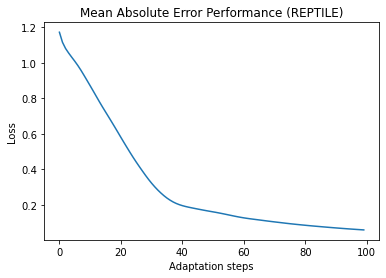

=======  2  run ========


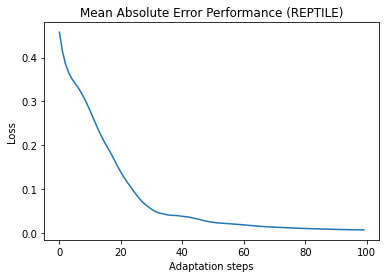

=======  3  run ========


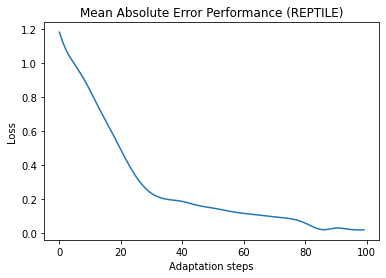

=======  4  run ========


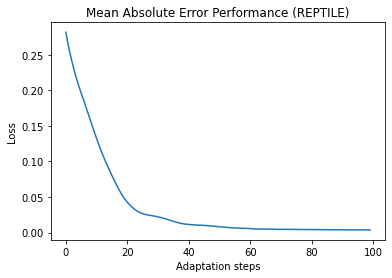

=======  5  run ========


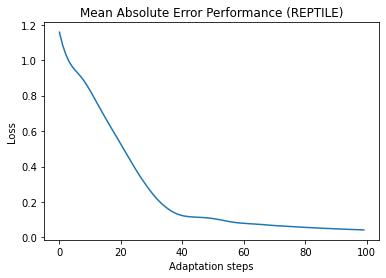

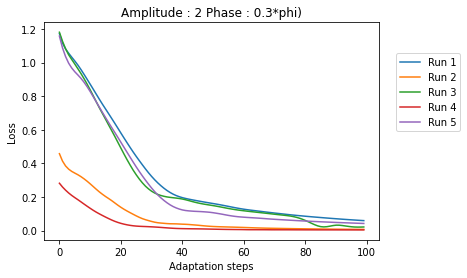

Amplitude : 3 Phase : 0.5*phi)
=======  1  run ========


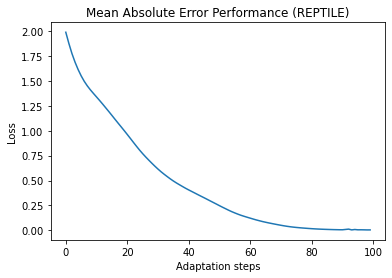

=======  2  run ========


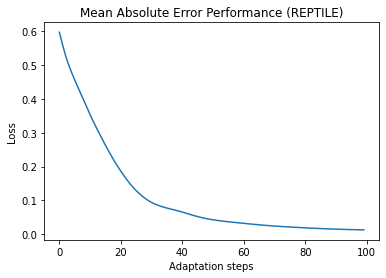

=======  3  run ========


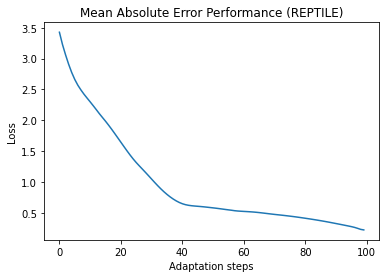

=======  4  run ========


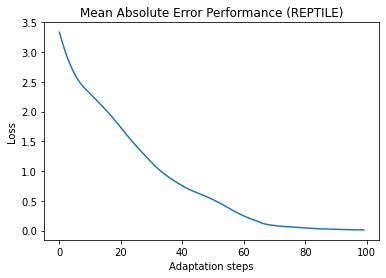

=======  5  run ========


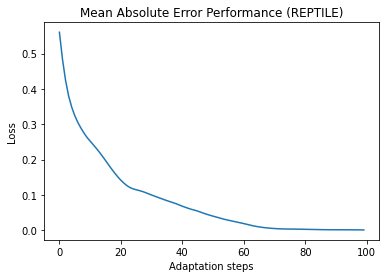

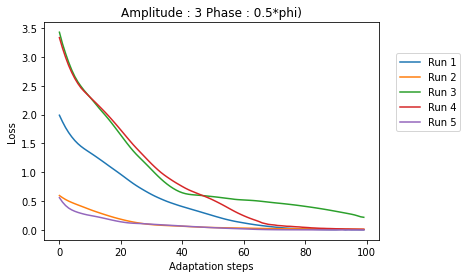

Amplitude : 4 Phase : 0.7*phi)
=======  1  run ========


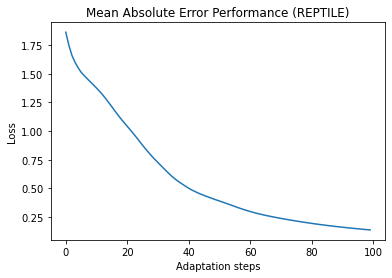

=======  2  run ========


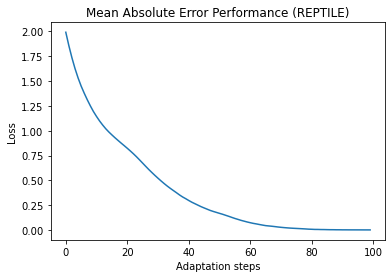

=======  3  run ========


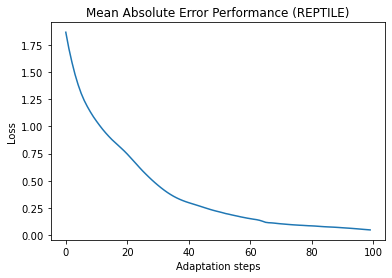

=======  4  run ========


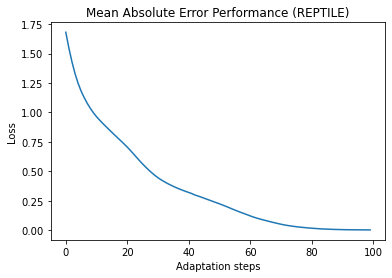

=======  5  run ========


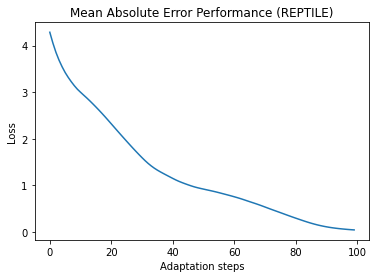

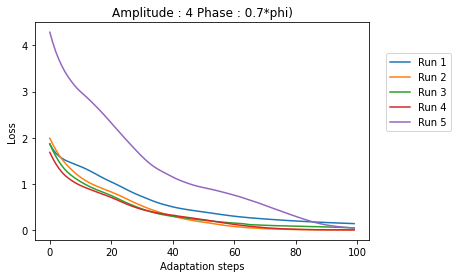

Amplitude : 5 Phase : 0.9*phi)
=======  1  run ========


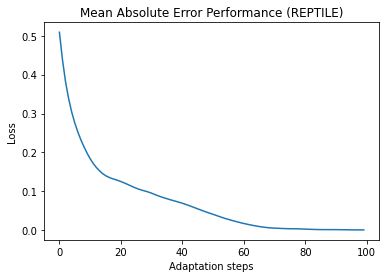

=======  2  run ========


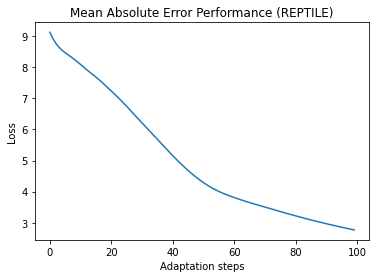

=======  3  run ========


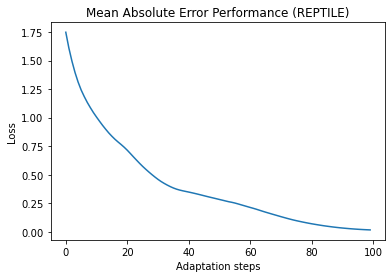

=======  4  run ========


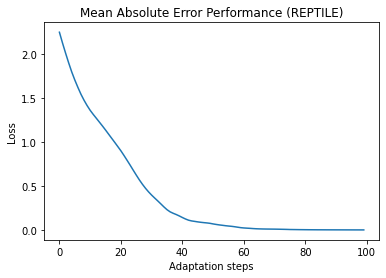

=======  5  run ========


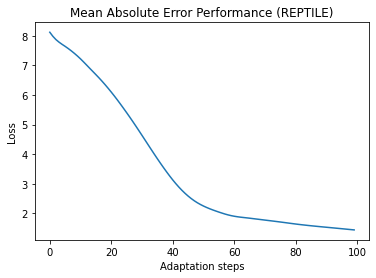

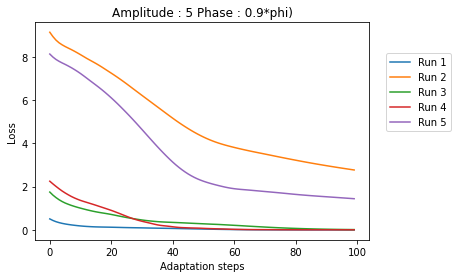

Amplitude : 6 Phase : 1*phi)
=======  1  run ========


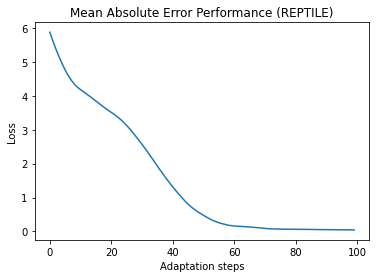

=======  2  run ========


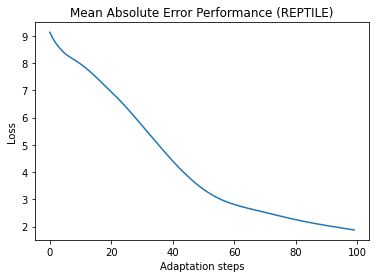

=======  3  run ========


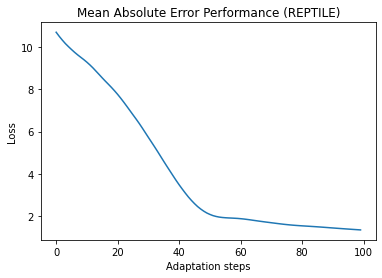

=======  4  run ========


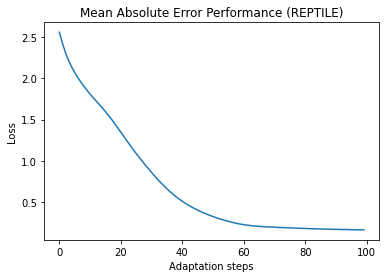

=======  5  run ========


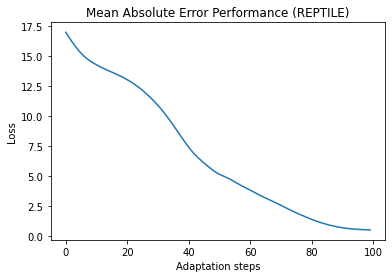

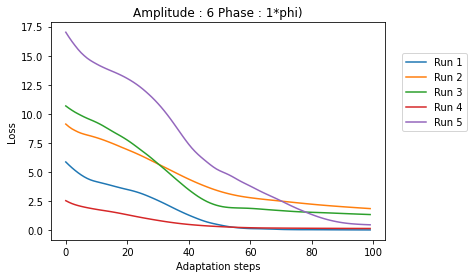

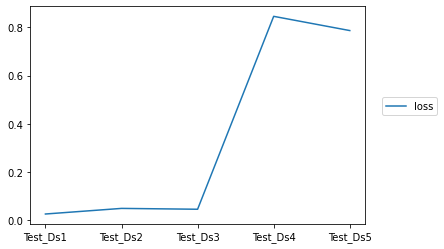

In [ ]:
reptile_res = test_session(reptile[0], train_reptile)

Amplitude : 2 Phase : 0.3*phi)
=======  1  run ========


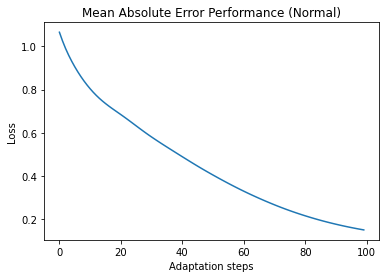

=======  2  run ========


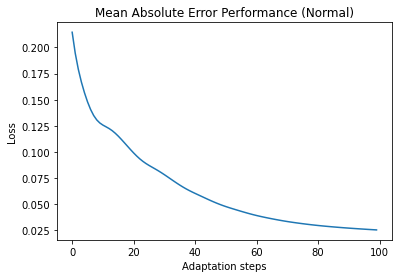

=======  3  run ========


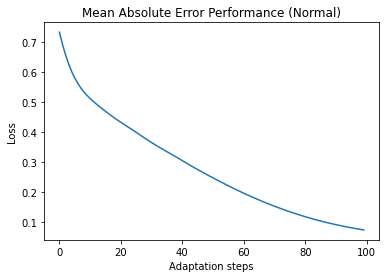

=======  4  run ========


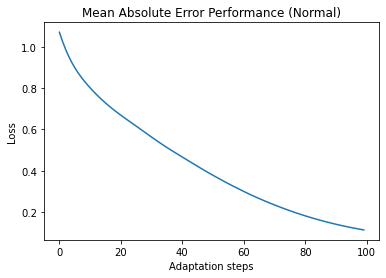

=======  5  run ========


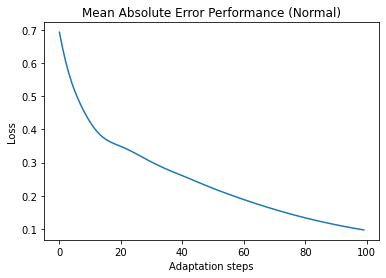

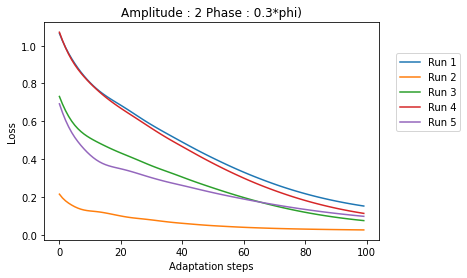

Amplitude : 3 Phase : 0.5*phi)
=======  1  run ========


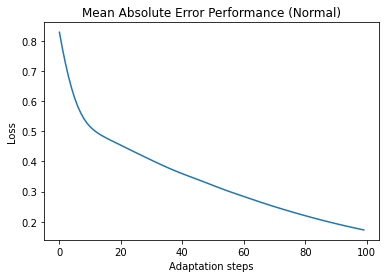

=======  2  run ========


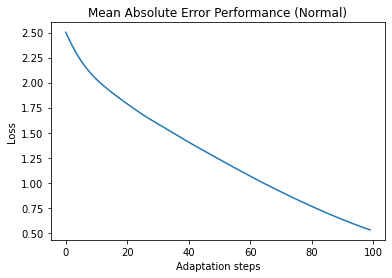

=======  3  run ========


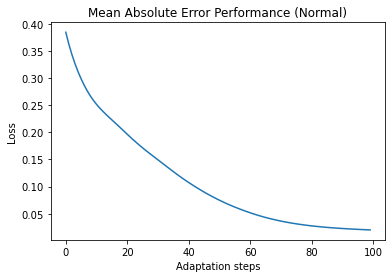

=======  4  run ========


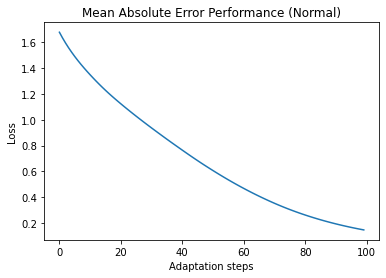

=======  5  run ========


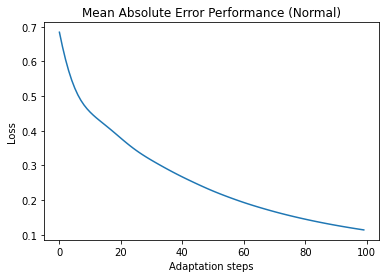

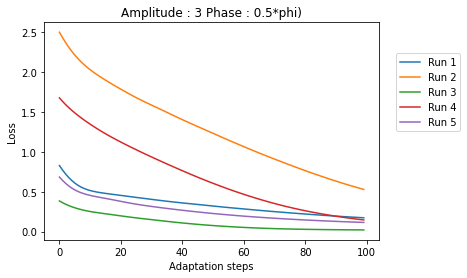

Amplitude : 4 Phase : 0.7*phi)
=======  1  run ========


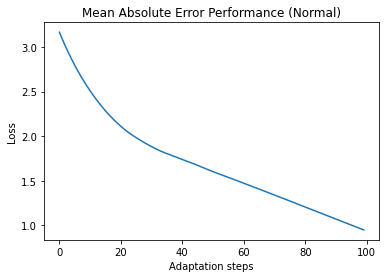

=======  2  run ========


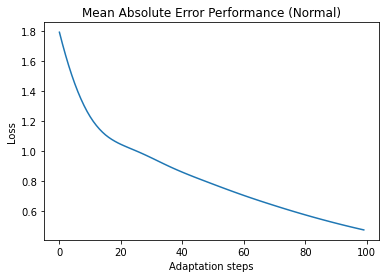

=======  3  run ========


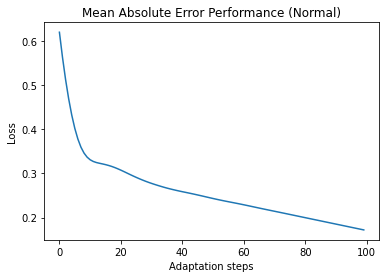

=======  4  run ========


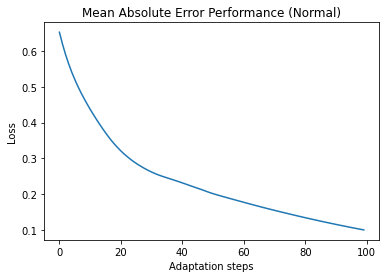

=======  5  run ========


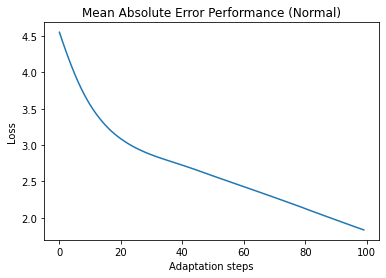

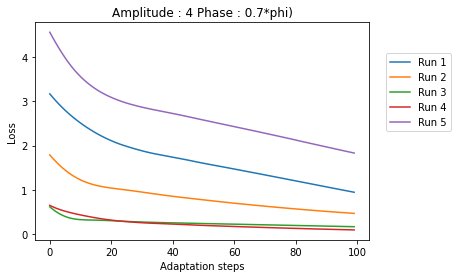

Amplitude : 5 Phase : 0.9*phi)
=======  1  run ========


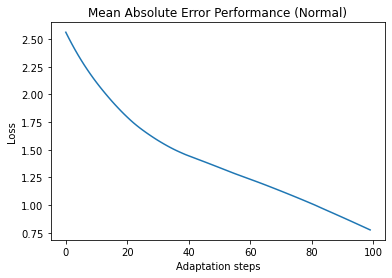

=======  2  run ========


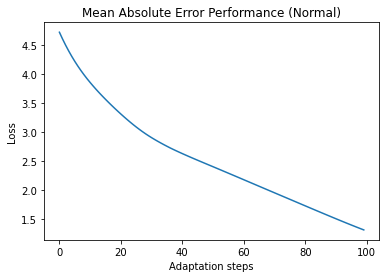

=======  3  run ========


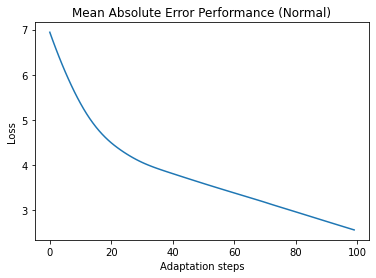

=======  4  run ========


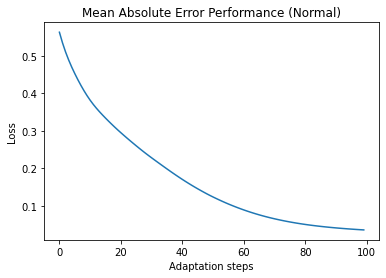

=======  5  run ========


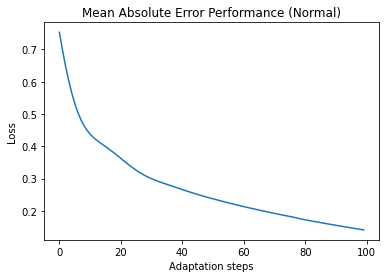

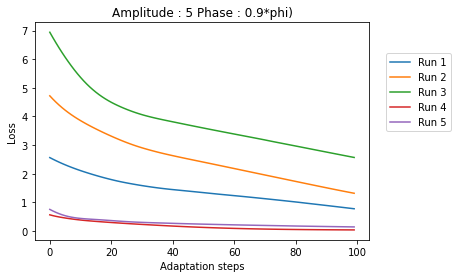

Amplitude : 6 Phase : 1*phi)
=======  1  run ========


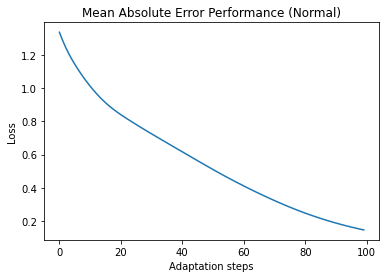

=======  2  run ========


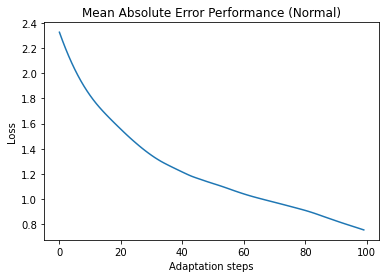

=======  3  run ========


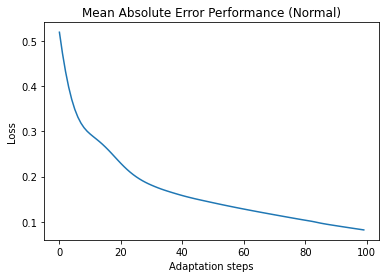

=======  4  run ========


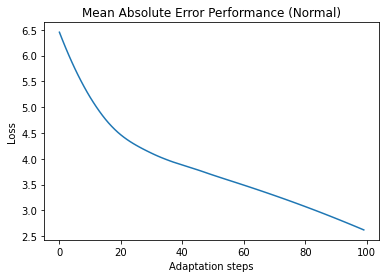

=======  5  run ========


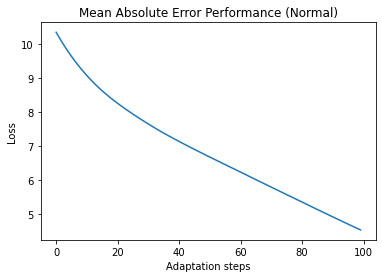

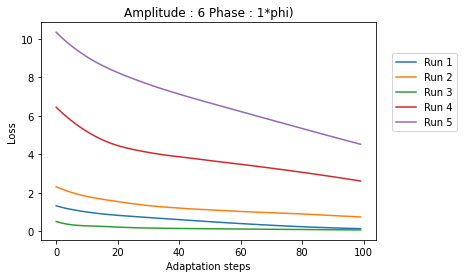

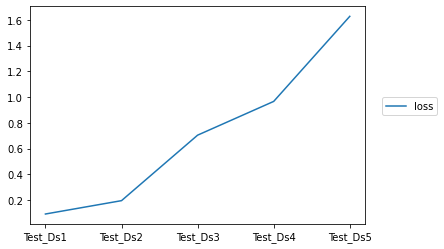

In [ ]:
nn_res = test_session(nn[0], train_reg)

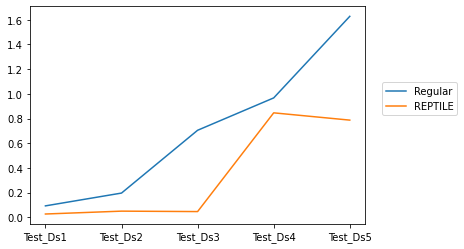

In [ ]:
category = ["Test_Ds1", "Test_Ds2", "Test_Ds3","Test_Ds4","Test_Ds5"]
fig, ax = plt.subplots()
ax.plot(category, nn_res, label="Regular")
ax.plot(category, reptile_res, label="REPTILE")
ax.legend(loc=(1.05, 0.5))
plt.show()